In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from scipy.fft import fft, fftfreq
from scipy.stats import kurtosis, skew
from scipy import signal
from scipy.signal import find_peaks
from scipy.signal import welch


In [3]:
# Загрузим файлы
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

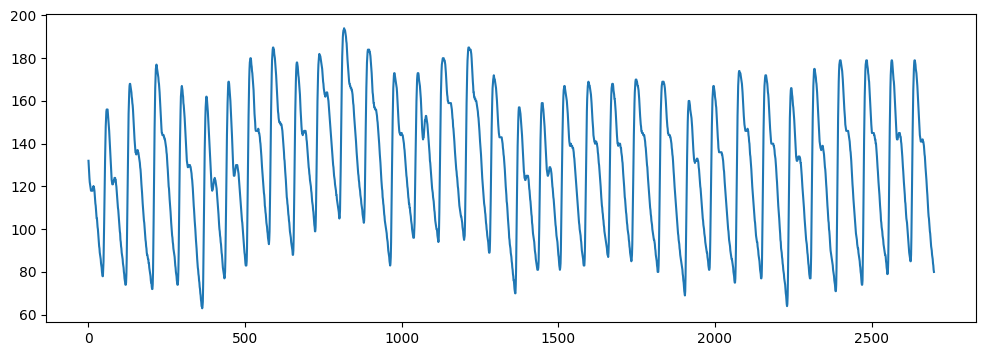

In [5]:
file_id = train.iloc[1]['ID']
path = 'data/ppgs/' + file_id + '.npy'
ppg = np.load(path)
plt.figure(figsize=(12,4))
plt.plot(ppg)

In [6]:
train, val = train_test_split(train, test_size=0.2, stratify=train['ЛПНП'], random_state=42)
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

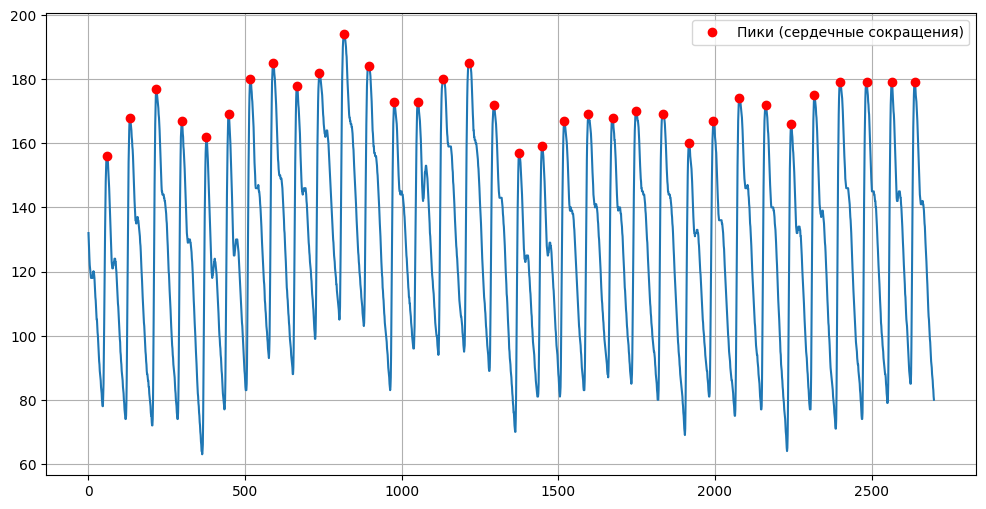

In [7]:

simple_rate = 100 # Гц по условию
# Находим пики (параметры можно настроить под ваш сигнал)
peaks, _ = find_peaks(ppg, height=100, distance=50)  # height и distance зависят от данных

# Визуализация пиков
plt.figure(figsize=(12, 6))
plt.plot(ppg)
plt.plot(peaks, ppg[peaks], 'ro', label='Пики (сердечные сокращения)')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Вычисляем интервалы между пиками (в отсчетах)
intervals = np.diff(peaks) / simple_rate
heart_rate = 60 / intervals 
# Делим сигнал на отдельные такты
beats = []
for i in range(len(peaks) - 1):
    beat = ppg[peaks[i]:peaks[i+1]]
    beats.append(beat)

In [9]:
features = []
for beat in beats:
    features.append({
        'mean_amp': np.mean(beat),
        'max_amp': np.max(beat),
        'min_amp': np.min(beat),
        'duration': len(beat),
        'area': np.trapz(beat),
        'std_amp': np.std(beat),
        'crest_factor': np.max(beat)/np.std(beat),
        'kurtosis': kurtosis(ppg),
        'skewness': skew(ppg)
    })

# Преобразуем в DataFrame (для удобства)

df_features = pd.DataFrame(features)
print(df_features.head(7))

     mean_amp  max_amp  min_amp  duration     area    std_amp  crest_factor  \
0  115.123288      167       74        73   8242.5  25.766573      6.481265   
1  120.635294      176       72        85  10082.0  31.030856      5.671774   
2  125.962963      177       74        81  10031.5  31.646756      5.592990   
3  114.897436      167       63        78   8798.5  31.318705      5.332277   
4  118.084507      168       77        71   8219.0  25.398651      6.614525   
5  126.157143      179       83        70   8657.0  26.754778      6.690394   
6  138.083333      184       93        72   9760.0  26.717530      6.886864   

   kurtosis  skewness  
0 -1.015004 -0.066193  
1 -1.015004 -0.066193  
2 -1.015004 -0.066193  
3 -1.015004 -0.066193  
4 -1.015004 -0.066193  
5 -1.015004 -0.066193  
6 -1.015004 -0.066193  


/var/folders/pq/h3m2swtj4hq9bdmryvdvt7qw0000gp/T/ipykernel_28967/960944153.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  'area': np.trapz(beat),


In [11]:
def process_ppg_signal(ppg, sampling_rate):
    def bandpass_filter(data, order=4):
        b, a = signal.butter(3, [0.8 / 100, 5 / 100], 'bandpass')
        return signal.filtfilt(b, a, ppg)  


    ppg = bandpass_filter(ppg)
    # Находим пики (параметры можно настроить под ваш сигнал)
    peaks, _ = find_peaks(ppg, height=100, distance=50)  # height и distance зависят от данных
    # Обрезаем сигнал до длины, кратной 128
    ppg = ppg[:128*20] 

    # Вычисляем интервалы между пиками (в отсчетах)
    intervals = np.diff(peaks) / simple_rate
    heart_rate = 60 / intervals 
    # Делим сигнал на отдельные такты
    beats = []
    for i in range(len(peaks) - 1):
        beat = ppg[peaks[i]:peaks[i+1]]
        beats.append(beat)
    

    beat_features = []
    for beat in beats:
        beat_features.append({
            'mean_amp': np.mean(beat),
            'max_amp': np.max(beat),
            'min_amp': np.min(beat),
            'duration': len(beat)/sampling_rate,
            'peak_to_peak': abs(np.max(beat) - np.min(beat)),
            'slope': (np.max(beat) - np.min(beat))/len(beat),
            'area': np.trapezoid(beat),
            'std_amp': np.std(beat),
        })
    beat_df_features = pd.DataFrame(beat_features)
    agg_features = {
            'mean_amp': beat_df_features['mean_amp'].mean(),
            'mean_max_amp': beat_df_features['max_amp'].mean(),
            'mean_min_amp': beat_df_features['min_amp'].mean(),
            'duration_std': beat_df_features['duration'].std(),
            'mean_peak_to_peak': beat_df_features['peak_to_peak'].mean(), # можно изменить
            'mean_slope': beat_df_features['slope'].mean(), # maybe change
            'total_area': beat_df_features['area'].sum(),
            'mean_std_amp': beat_df_features['std_amp'].mean(), # maybe change
    }
    # Производные
    gradient = np.gradient(ppg)
    agg_features['max_gradient'] = np.max(gradient)
    agg_features['min_gradient'] = np.min(gradient)
    agg_features['mean_gradient'] = np.mean(gradient)

    second_derivative = np.gradient(gradient)
    agg_features['zero_crossings'] = np.count_nonzero(second_derivative == 0)
    


    # Спектральные признаки
    n = len(ppg)
    fft_result = np.abs(fft(ppg - np.mean(ppg)))
    frequencies = fftfreq(n, 1/sampling_rate)
    positive_freq = frequencies[:n//2]
    magnitude = fft_result[:n//2] * 2 / n
    dominant_freq = positive_freq[np.argmax(magnitude)]
    freqs, psd = welch(ppg, fs=sampling_rate, nperseg=1024)

    dominant_idx = np.argmax(magnitude[(positive_freq >= 0.5) & (positive_freq <= 3)])  # Диапазон ЧСС
    dominant_amp = magnitude[(positive_freq >= 0.5) & (positive_freq <= 3)][dominant_idx]

    hr_range = (0.5, 3)  # Диапазон ЧСС в Гц
    n_harmonics = 2
    dominant_idx = np.argmax(magnitude[(positive_freq >= hr_range[0]) & (positive_freq <= hr_range[1])])
    dominant_freq = positive_freq[(positive_freq >= hr_range[0]) & (positive_freq <= hr_range[1])][dominant_idx]
    dominant_mag = magnitude[(positive_freq >= hr_range[0]) & (positive_freq <= hr_range[1])][dominant_idx]

    
    # LF (0.04–0.15 Гц) и HF (0.15–0.4 Гц)
    lf_power = np.sum(psd[(freqs >= 0.04) & (freqs < 0.15)])
    hf_power = np.sum(psd[(freqs >= 0.15) & (freqs < 0.4)])


    power_ratio = lf_power / hf_power   
    print(power_ratio)
    def get_respiration_rate(freqs, psd):
        resp_range = (0.1, 0.4)  # Диапазон дыхания (Гц)
    
        # Находим пик в дыхательном диапазоне
        mask = (freqs >= resp_range[0]) & (freqs <= resp_range[1])
        resp_freq = freqs[mask][np.argmax(psd[mask])]
        respiration_rate = resp_freq * 60  # Переводим в удары/мин
    
        return respiration_rate

    respiration_rate = get_respiration_rate(ppg_data, sampling_rate=100)
    print(f"Частота дыхания: {respiration_rate:.1f} дыханий/мин")

    freqs, psd = welch(ppg_data, fs=sampling_rate, nperseg=1024)
    
    # LF (0.04–0.15 Гц) и HF (0.15–0.4 Гц)
    lf_power = np.sum(psd[(freqs >= 0.04) & (freqs < 0.15)])
    hf_power = np.sum(psd[(freqs >= 0.15) & (freqs < 0.4)])


    power_ratio = lf_power / hf_power
    print(f"LF/HF power ratio: {power_ratio:.2f}")

    spectr_features = {
        'dominant_freq_hz': dominant_freq,
        'spectral_power': np.sum(magnitude[(positive_freq > 0.5) & (positive_freq < 4)]),
        'kurtosis': kurtosis(ppg),
        'skewness': skew(ppg),
        'dominant_amp': dominant_amp,
        'power_ratio': power_ratio,
        'respiration_rate': respiration_rate
    }


    # Генерация нелинейных признаков
    nn_intervals = np.diff(peaks) / sampling_rate * 1000  # В миллисекундах
    sdnn = np.std(nn_intervals) # Стандартное отклонение интервалов NN (нормальных тактов).
    rmssd = np.sqrt(np.mean(np.diff(nn_intervals)**2)) # Корень из среднего квадратов разностей последовательных интервалов.
    pnn50 = np.sum(np.abs(np.diff(nn_intervals)) > 50) / len(nn_intervals) * 100 # Процент интервалов с разницей >50 мс.

    gen_features = {
        'sdnn': sdnn,
        'rmssd': rmssd,
        'pnn50': pnn50
    }
    features = {
        **agg_features,
        **spectr_features,
        **getfeatures
    }
    print(features)
process_ppg_signal(ppg, 100)

KeyError: 'mean_amp'

In [12]:
features = []
for beat in beats:
    features.append({
        'mean_amp': np.mean(beat),
        'max_amp': np.max(beat),
        'min_amp': np.min(beat),
        'duration': len(beat),
        'peak_to_peak': abs(np.max(beat) - np.min(beat)),
        'slope': (np.max(beat) - np.min(beat))/len(beat),
        'area': np.trapz(beat),
        'std_amp': np.std(beat),
    })
beat_df_features = pd.DataFrame(features)
avr = beat_df_features.mean()
df_features = pd.DataFrame(avr).T
print(df_features.head())

     mean_amp     max_amp    min_amp   duration  peak_to_peak     slope  \
0  128.864549  175.636364  82.030303  78.121212     93.606061  1.199096   

          area    std_amp  
0  9895.818182  28.378828  


/var/folders/pq/h3m2swtj4hq9bdmryvdvt7qw0000gp/T/ipykernel_28967/3136927055.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  'area': np.trapz(beat),


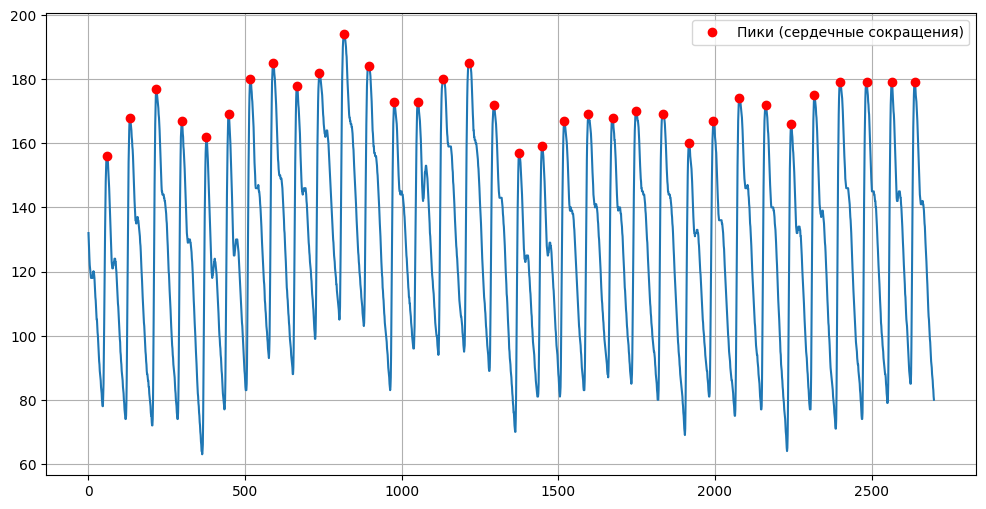

In [13]:

simple_rate = 100 # Гц по условию
# Находим пики (параметры можно настроить под ваш сигнал)
peaks, _ = find_peaks(ppg, height=100, distance=50)  # height и distance зависят от данных

# Визуализация пиков
plt.figure(figsize=(12, 6))
plt.plot(ppg)
plt.plot(peaks, ppg[peaks], 'ro', label='Пики (сердечные сокращения)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
gradient = np.gradient(ppg)
df_features['max_gradient'] = np.max(gradient)
df_features['min_gradient'] = np.min(gradient)
df_features['mean_gradient'] = np.mean(gradient)

In [15]:
second_derivative = np.gradient(gradient)
df_features['zero_crossings'] = np.count_nonzero(second_derivative == 0)

In [16]:
df_features

,mean_amp,max_amp,min_amp,duration,peak_to_peak,slope,area,std_amp,max_gradient,min_gradient,mean_gradient,zero_crossings
0,128.864549,175.636364,82.030303,78.121212,93.606061,1.199096,9895.818182,28.378828,15.5,-4.0,-0.02,713


In [17]:
ppg_normalized = ppg - np.mean(ppg)

In [18]:
sampling_rate = 100  # Частота дискретизации (Гц). Уточните для ваших данных!
n = len(ppg_normalized)  # Количество отсчетов
duration = n / sampling_rate  # Длительность сигнала в секундах

In [19]:
n = len(ppg_data)
fft_result = np.abs(fft(ppg_data - np.mean(ppg_data)))
frequencies = fftfreq(n, 1/sampling_rate)
positive_freq = frequencies[:n//2]
magnitude = fft_result[:n//2] * 2 / n
dominant_freq = positive_freq[np.argmax(magnitude)]
freqs, psd = welch(ppg_data, fs=sampling_rate, nperseg=1024)

dominant_idx = np.argmax(magnitude[(positive_freq >= 0.5) & (positive_freq <= 3)])  # Диапазон ЧСС
dominant_amp = magnitude[(positive_freq >= 0.5) & (positive_freq <= 3)][dominant_idx]

hr_range = (0.5, 3)  # Диапазон ЧСС в Гц
n_harmonics = 2
dominant_idx = np.argmax(magnitude[(positive_freq >= hr_range[0]) & (positive_freq <= hr_range[1])])
dominant_freq = positive_freq[(positive_freq >= hr_range[0]) & (positive_freq <= hr_range[1])][dominant_idx]
dominant_mag = magnitude[(positive_freq >= hr_range[0]) & (positive_freq <= hr_range[1])][dominant_idx]



    
print(f"Отношение гармоник: {harmonics}")
print(f"Амплитуда доминирующей частоты: {dominant_amp:.2f}")

NameError: name 'ppg_data' is not defined

Power_ratio. Отношение HF/LF

In [20]:
freqs, psd = welch(ppg_data, fs=sampling_rate, nperseg=1024)
    
# LF (0.04–0.15 Гц) и HF (0.15–0.4 Гц)
lf_power = np.sum(psd[(freqs >= 0.04) & (freqs < 0.15)])
hf_power = np.sum(psd[(freqs >= 0.15) & (freqs < 0.4)])


power_ratio = lf_power / hf_power
print(f"LF/HF power ratio: {power_ratio:.2f}")

NameError: name 'ppg_data' is not defined

In [21]:
def get_respiration_rate(ppg_data, sampling_rate):
    freqs, psd = welch(ppg_data, fs=sampling_rate, nperseg=1024)
    resp_range = (0.1, 0.4)  # Диапазон дыхания (Гц)
    
    # Находим пик в дыхательном диапазоне
    mask = (freqs >= resp_range[0]) & (freqs <= resp_range[1])
    resp_freq = freqs[mask][np.argmax(psd[mask])]
    respiration_rate = resp_freq * 60  # Переводим в удары/мин
    
    return respiration_rate

respiration_rate = get_respiration_rate(ppg_data, sampling_rate=100)
print(f"Частота дыхания: {respiration_rate:.1f} дыханий/мин")

NameError: name 'ppg_data' is not defined

In [22]:
df_features['dominant_freq_hz'] = dominant_freq
df_features['spectral_power'] = np.sum(magnitude[(positive_freq > 0.5) & (positive_freq < 4)])
df_features['kurtosis'] = kurtosis(ppg)
df_features['skewness'] = skew(ppg)
df_features['dominant_amp'] = dominant_amp
df_features['power_ratio'] = power_ratio
df_features['respiration_rate'] = respiration_rate

NameError: name 'dominant_freq' is not defined

Генерация нелинейных признаков

In [23]:
nn_intervals = np.diff(peaks) / sampling_rate * 1000  # В миллисекундах
sdnn = np.std(nn_intervals) # Стандартное отклонение интервалов NN (нормальных тактов).
rmssd = np.sqrt(np.mean(np.diff(nn_intervals)**2)) # Корень из среднего квадратов разностей последовательных интервалов.
pnn50 = np.sum(np.abs(np.diff(nn_intervals)) > 50) / len(nn_intervals) * 100 # Процент интервалов с разницей >50 мс.

In [24]:
df_features['sdnn'] = sdnn
df_features['rmssd'] = rmssd
df_features['pnn50'] = pnn50

In [25]:
df_features.corr()

,mean_amp,max_amp,min_amp,duration,peak_to_peak,slope,area,std_amp,max_gradient,min_gradient,mean_gradient,zero_crossings,sdnn,rmssd,pnn50
mean_amp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_amp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min_amp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
peak_to_peak,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
slope,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
area,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std_amp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_gradient,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min_gradient,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df_features.head()

,mean_amp,max_amp,min_amp,duration,peak_to_peak,slope,area,std_amp,max_gradient,min_gradient,mean_gradient,zero_crossings,sdnn,rmssd,pnn50
0,128.864549,175.636364,82.030303,78.121212,93.606061,1.199096,9895.818182,28.378828,15.5,-4.0,-0.02,713,45.377713,52.5,30.30303


In [27]:
plt.figure(figsize=(12, 5))
plt.plot(positive_freq, magnitude, label='Спектр ФПГ')
plt.xlabel('Частота (Гц)')
plt.ylabel('Амплитуда')
plt.title('Спектр фотоплетизмограммы')
plt.grid(True)
plt.xlim(0, 5)  # Ограничение по частоте (например, до 5 Гц для ЧСС)
plt.legend()
plt.show()

NameError: name 'positive_freq' is not defined

<Figure size 1200x500 with 0 Axes>

In [28]:
df_features.head()

,mean_amp,max_amp,min_amp,duration,peak_to_peak,slope,area,std_amp,max_gradient,min_gradient,mean_gradient,zero_crossings,sdnn,rmssd,pnn50
0,128.864549,175.636364,82.030303,78.121212,93.606061,1.199096,9895.818182,28.378828,15.5,-4.0,-0.02,713,45.377713,52.5,30.30303


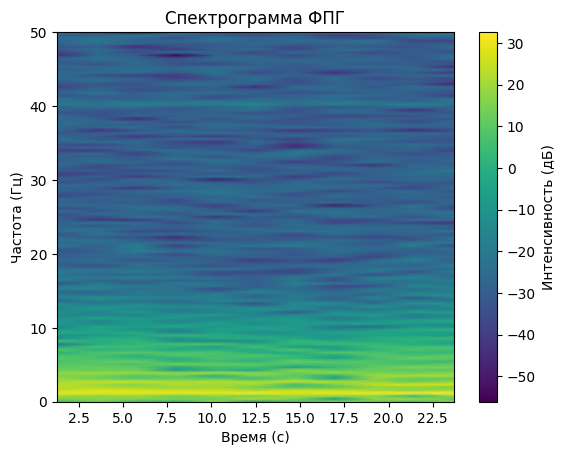

In [29]:
from scipy.signal import spectrogram

f, t, Sxx = spectrogram(ppg_normalized, fs=sampling_rate, nperseg=256)
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Частота (Гц)')
plt.xlabel('Время (с)')
plt.title('Спектрограмма ФПГ')
plt.colorbar(label='Интенсивность (дБ)')
plt.show()

In [30]:
import numpy as np
from scipy.signal import find_peaks
from scipy.stats import kurtosis, skew
from scipy.fft import fft, fftfreq

# Загрузка данных ФПГ
ppg_data = ppg
sampling_rate = 100  # Частота дискретизации (Гц)

# 1. Временные признаки (пики и такты)
peaks, _ = find_peaks(ppg_data, distance=sampling_rate*0.6)  # Предполагаем ЧСС < 100 уд/мин
intervals = np.diff(peaks) / sampling_rate  # Интервалы в секундах
heart_rate = 60 / intervals  # ЧСС для каждого интервала

# 2. Частотные признаки (FFT)
n = len(ppg_data)
fft_result = np.abs(fft(ppg_data - np.mean(ppg_data)))
frequencies = fftfreq(n, 1/sampling_rate)
positive_freq = frequencies[:n//2]
magnitude = fft_result[:n//2] * 2 / n
dominant_freq = positive_freq[np.argmax(magnitude)]

# 3. Создание датасета
features = {
    'mean_hr': np.mean(heart_rate),
    'std_hr': np.std(heart_rate),
    'dominant_freq_hz': dominant_freq,
    'spectral_power': np.sum(magnitude[(positive_freq > 0.5) & (positive_freq < 4)]),
    'kurtosis': kurtosis(ppg_data),
    'skewness': skew(ppg_data),
}

print(features)

{'mean_hr': np.float64(77.0664898622238), 'std_hr': np.float64(4.530306223380497), 'dominant_freq_hz': np.float64(1.259259259259259), 'spectral_power': np.float64(235.97211994145792), 'kurtosis': np.float64(-1.0150044604236557), 'skewness': np.float64(-0.06619343705635466)}
